In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_DRIVER_MEMORY"] = "8g"


from zoo.common.nncontext import *
sc = init_nncontext("Anomaly-Detection-Temperature")
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing

Prepending /home/user/anaconda3/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/user/anaconda3/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/user/anaconda3/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
pyspark_submit_args is:  --driver-class-path /home/user/anaconda3/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar:/home/user/anaconda3/lib/python3.7/site-packages/bigdl/share/lib/bigdl-0.12.1-jar-with-dependencies.jar pyspark-shell 
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.getConf().getAll()

[('spark.app.name', 'Anomaly-Detection-Temperature'),
 ('spark.executorEnv.OMP_NUM_THREADS', '1'),
 ('spark.serializer', 'org.apache.spark.serializer.JavaSerializer'),
 ('spark.driver.host', 'gjlee'),
 ('spark.shuffle.reduceLocality.enabled', 'false'),
 ('spark.executor.id', 'driver'),
 ('spark.shuffle.blockTransferService', 'nio'),
 ('spark.executorEnv.KMP_BLOCKTIME', '0'),
 ('spark.driver.port', '39057'),
 ('spark.executorEnv.KMP_AFFINITY', 'granularity=fine,compact,1,0'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.extraClassPath',
  '/home/user/anaconda3/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar:/home/user/anaconda3/lib/python3.7/site-packages/bigdl/share/lib/bigdl-0.12.1-jar-with-dependencies.jar'),
 ('spark.speculation', 'false'),
 ('spark.driver.memory', '8g'),
 ('spark.scheduler.maxRegisteredResourcesWaitingTime', '3600s'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 

In [3]:
from zoo.pipeline.api.keras.layers import Dense, Dropout, LSTM
from zoo.pipeline.api.keras.models import Sequential

In [4]:
columns_list = ['serial','division','ddust','dust','temperature','relative_humidity',
               'measure_time', 'timestamp']

try:
    dataset_path = "../data/Seoul-sensor-data/S-DoT_NATURE_2020.07.01-07.31.csv"
    df = pd.read_csv(dataset_path, encoding='cp949')
    df.drop(columns = df.columns[:4], axis=1, inplace=True)
    df.drop(columns = df.columns[6:22], axis=1, inplace=True)
    df.columns = columns_list
except Exception as e:
    print("CSV doesn't exist")

'''
dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.05.01-05.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.06.01-06.30.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.07.01-07.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)
'''
dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.08.01-08.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.09.01-09.30.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[0], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:-2], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.10.01-10.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[0], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:-2], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)


In [5]:
#df.iloc[8, 23]

df['timestamp'].dropna()
df['temperature'] = pd.to_numeric(df['temperature'], errors = 'coerce') 
df = df.astype({'temperature': 'float64'})



In [6]:
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2387973 entries, 0 to 2387972
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   serial             object 
 1   division           int64  
 2   ddust              float64
 3   dust               float64
 4   temperature        float64
 5   relative_humidity  float64
 6   measure_time       object 
 7   timestamp          object 
dtypes: float64(4), int64(1), object(3)
memory usage: 145.8+ MB
None
        serial  division  ddust  dust  temperature  relative_humidity  \
0  V02Q1940044         1    2.0   3.0         21.3               79.0   
1  V02Q1940045         1    3.0   4.0         21.1               80.0   
2  V02Q1940047         1    3.0   4.0         21.2               78.0   
3  V02Q1940050         1    2.0   3.0         20.5               84.0   
4  V02Q1940051         1    2.0   3.0         21.2               79.0   
5  V02Q1940052         1    2.0   4.0         22.2           

In [7]:
node_mask = (df.serial == 'V02Q1940043')
df_node = df.loc[node_mask, :]
df_node = df_node.reset_index(drop=True)
print(df_node['timestamp'].head(10))

0     2020.7.1 2:45
1     2020.7.1 3:45
2     2020.7.1 4:45
3     2020.7.1 5:45
4     2020.7.1 6:45
5     2020.7.1 7:45
6     2020.7.1 8:45
7     2020.7.1 9:45
8    2020.7.1 10:45
9    2020.7.1 11:45
Name: timestamp, dtype: object


In [8]:
df_node

,serial,division,ddust,dust,temperature,relative_humidity,measure_time,timestamp
0,V02Q1940043,1,2.0,3.0,21.1,78.0,2020.7.1 2:45,2020.7.1 2:45
1,V02Q1940043,1,2.0,3.0,20.9,77.0,2020.7.1 3:45,2020.7.1 3:45
2,V02Q1940043,1,2.0,3.0,21.2,75.0,2020.7.1 4:45,2020.7.1 4:45
3,V02Q1940043,1,2.0,4.0,21.3,76.0,2020.7.1 5:45,2020.7.1 5:45
4,V02Q1940043,1,3.0,4.0,21.4,76.0,2020.7.1 6:45,2020.7.1 6:45
...,...,...,...,...,...,...,...,...
2881,V02Q1940043,1,3.0,5.0,17.2,51.0,2020-10-31 19:00:00,2020-10-31 19:00:00
2882,V02Q1940043,1,3.0,5.0,17.0,51.0,2020-10-31 20:00:00,2020-10-31 20:00:00
2883,V02Q1940043,1,3.0,4.0,17.1,49.0,2020-10-31 21:00:00,2020-10-31 21:00:00
2884,V02Q1940043,1,3.0,4.0,17.0,48.0,2020-10-31 22:00:00,2020-10-31 22:00:00


In [9]:
print(df_node['temperature'].mean())

24.04050589050588


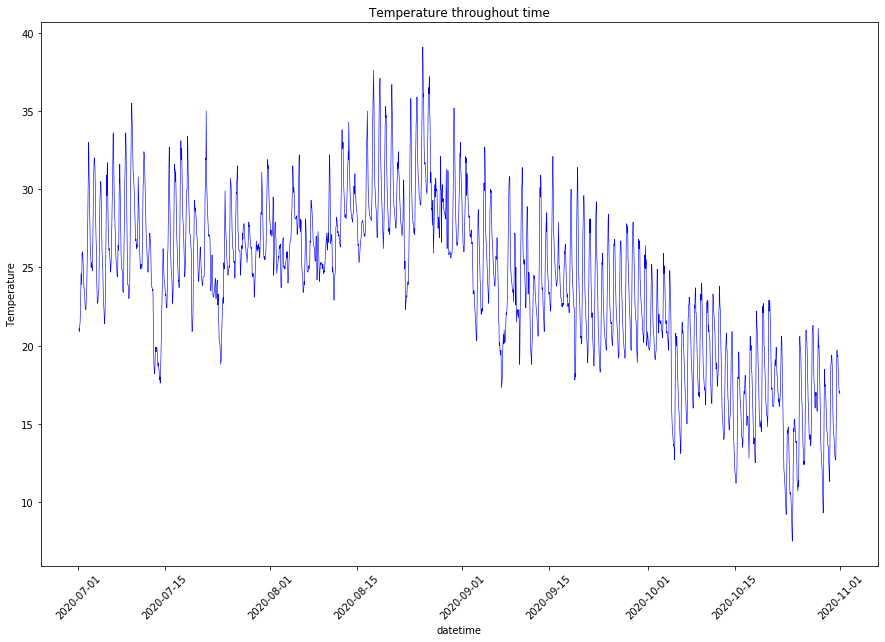

In [10]:
df_node['datetime'] = pd.to_datetime(df_node['timestamp'])

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_node['datetime'], df_node['temperature'], color='blue', linewidth=0.6)
ax.set_title('Temperature throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('Temperature')
plt.show()

In [11]:
df_node['hours'] = df_node['datetime'].dt.hour
df_node['daylight'] = ((df_node['hours'] >= 7) & (df_node['hours'] <= 22)).astype(int)
df_node['DayOfTheWeek'] = df_node['datetime'].dt.dayofweek
df_node['WeekDay'] = (df_node['DayOfTheWeek'] < 5).astype(int)


# Anomaly estimated population
outliers_fraction = 0.01

df_node['time_epoch'] = (df_node['datetime'].astype(np.int64)/100000000000).astype(np.int64)

df_node['categories'] = df_node['WeekDay']*2 + df_node['daylight']
a = df_node.loc[df_node['categories'] == 0, 'temperature']
b = df_node.loc[df_node['categories'] == 1, 'temperature']
c = df_node.loc[df_node['categories'] == 2, 'temperature']
d = df_node.loc[df_node['categories'] == 3, 'temperature']

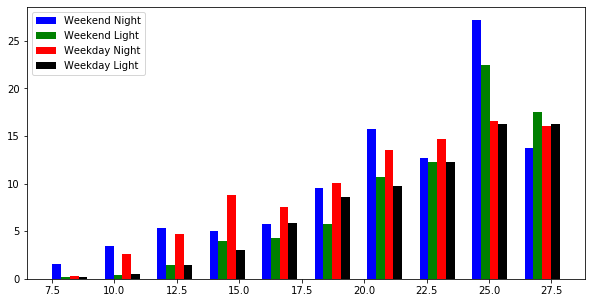

In [12]:
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

In [13]:
#Preparing the data for LSTM model
data_n = df_node[['temperature', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [14]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 500
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].to_numpy()
y_train = data_n[prediction_time:-testdatacut  ][0].to_numpy()

#Test data
x_test = data_n[0-testdatacut:-prediction_time].to_numpy()
y_test = data_n[prediction_time-testdatacut:  ][0].to_numpy()

In [15]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2284, 50, 5)
y_train (2284,)
x_test (500, 50, 5)
y_test (500,)


In [16]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_shape=(x_train.shape[1], x_train.shape[-1]),
    output_dim=60,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    120,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

creating: createZooKerasSequential
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError


In [17]:
%%time
# Train the model
print("Training begins.")
model.fit(
    x_train,
    y_train,
    batch_size=1024,
    nb_epoch=50)
print("Training completed.")

Training begins.
Training completed.
CPU times: user 35.5 ms, sys: 5.36 ms, total: 40.8 ms
Wall time: 1min 29s


In [18]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]
predictions = model.predict(x_test)
p = predictions.collect()
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [19]:
print(p)

[array([-1.2573001], dtype=float32), array([-1.3423539], dtype=float32), array([-1.3503232], dtype=float32), array([-1.2899405], dtype=float32), array([-1.1769763], dtype=float32), array([-0.8958474], dtype=float32), array([-0.6046861], dtype=float32), array([-0.34711745], dtype=float32), array([-0.0743798], dtype=float32), array([0.15753771], dtype=float32), array([0.14693548], dtype=float32), array([-0.08934982], dtype=float32), array([-0.3906995], dtype=float32), array([-0.63610625], dtype=float32), array([-0.7944051], dtype=float32), array([-0.91933805], dtype=float32), array([-0.95868766], dtype=float32), array([-0.96016335], dtype=float32), array([-1.0154136], dtype=float32), array([-1.0377116], dtype=float32), array([-1.0505426], dtype=float32), array([-1.1582985], dtype=float32), array([-1.2461114], dtype=float32), array([-1.3461684], dtype=float32), array([-1.3995922], dtype=float32), array([-1.4069741], dtype=float32), array([-1.3812108], dtype=float32), array([-1.2943523], d

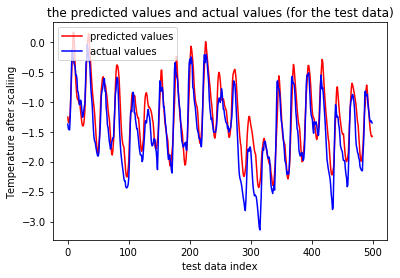

In [20]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()

axs.plot(p,color='red', label='predicted values')
axs.plot(y_test,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index')
plt.ylabel('Temperature after scaliing')
plt.legend(loc='upper left')
plt.show()

In [21]:
# An estimation of anomly population of the dataset
outliers_fraction = 0.01
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

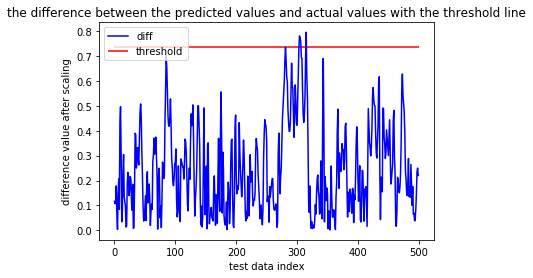

In [22]:
# plot the difference and the threshold (for the test data)
fig, axs = plt.subplots()

axs.plot(diff,color='blue', label='diff')
axs.set_title('the difference between the predicted values and actual values with the threshold line')

plt.hlines(threshold, 0, 500, color='red', label='threshold')
plt.xlabel('test data index')
plt.ylabel('difference value after scaling')
plt.legend(loc='upper left')
plt.show()

In [23]:
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly

complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
last_train_data= (df_node['datetime'].tolist())[-testdatasize] # test start timestamp
# add the data to the main
df_node['anomaly27'] = complement.append(test, ignore_index='True')
print(df_node['anomaly27'])

0       0
1       0
2       0
3       0
4       0
       ..
2881    0
2882    0
2883    0
2884    0
2885    0
Name: anomaly27, Length: 2886, dtype: int64


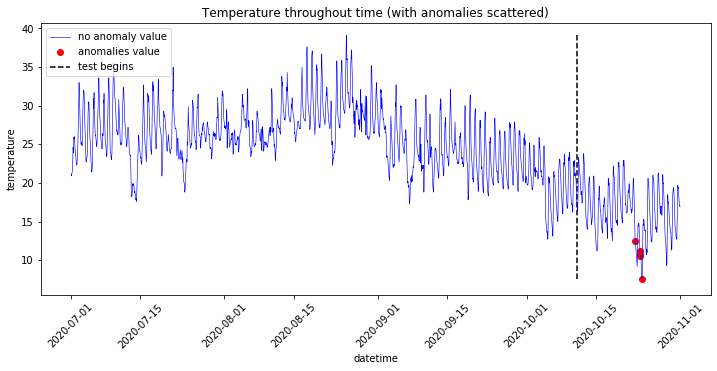

In [24]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

a = df_node.loc[df_node['anomaly27'] == 1, ['datetime', 'temperature']] #anomaly

ax.plot(df_node['datetime'], df_node['temperature'], color='blue', label='no anomaly value', linewidth=0.6)
ax.scatter(a['datetime'].tolist(),a['temperature'], color='red', label='anomalies value')
ax.set_title('Temperature throughout time (with anomalies scattered)')

max_value = df_node['temperature'].max()
min_value = df_node['temperature'].min()
plt.vlines(last_train_data, min_value, max_value, color='black', linestyles = "dashed", label='test begins')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.ylabel('temperature')
plt.legend(loc='upper left')
plt.show()